# Enhanced GCN-LSTM with Static Node Features for Crime Prediction

This notebook implements an enhanced GCN-LSTM architecture for crime prediction that incorporates static socioeconomic and demographic features through a sophisticated attention mechanism.

## Key Features:
1. **Static Feature Integration**: External socioeconomic features from CSV files
2. **Cross-Modal Attention**: Attention mechanism for static-temporal interaction  
3. **Multi-Head Attention**: Multiple attention heads for different feature aspects
4. **Feature-Aware Graph Convolution**: Static features influence spatial relationships
5. **Memory-Optimized Training**: Efficient hyperparameter search and training

## 1. Environment Setup and Imports

In [1]:
# Core imports
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import copy
import warnings
import zipfile
import io
import requests
import pickle
import glob
from pathlib import Path
import gc
from tqdm.auto import tqdm
import time

# Configuration
SEED = 42
WINDOW_SIZE = 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('default')

print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.5.1


/Users/goffy/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/goffy/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Memory optimization settings
from torch.cuda.amp import autocast, GradScaler

torch.backends.cudnn.enabled = True

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    try:
        torch.cuda.set_per_process_memory_fraction(0.7)
    except:
        print("Could not set memory fraction")

EFFICIENCY_CONFIG = {
    'use_mixed_precision': torch.cuda.is_available(),
    'max_batch_size': 8,
    'num_workers': 0,
    'pin_memory': False,
}

scaler = GradScaler() if EFFICIENCY_CONFIG['use_mixed_precision'] else None

def get_memory_usage():
    if torch.cuda.is_available():
        try:
            allocated = torch.cuda.memory_allocated() / 1024**3
            reserved = torch.cuda.memory_reserved() / 1024**3
            return allocated, reserved
        except:
            return 0, 0
    return 0, 0

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
        except:
            pass

print(f"Initial GPU memory - Allocated: {get_memory_usage()[0]:.2f}GB, Reserved: {get_memory_usage()[1]:.2f}GB")

Initial GPU memory - Allocated: 0.00GB, Reserved: 0.00GB


## 2. Data Loading Functions

In [3]:
def download_crime_data(data_dir=None, force_download=False):
    """Download crime data and shapefiles"""
    urls = {
        'recent_crime': 'https://raw.githubusercontent.com/IflyNY2PR/DSSS_cw/6bac9ee3834c73d705106153bf91b315bb1faf01/MPS%20LSOA%20Level%20Crime%20(most%20recent%2024%20months).csv',
        'historical_crime': 'https://raw.githubusercontent.com/IflyNY2PR/DSSS_cw/refs/heads/main/MPS%20LSOA%20Level%20Crime%20(Historical).csv',
        'shapefile': 'https://github.com/IflyNY2PR/DSSS_cw/raw/main/statistical-gis-boundaries-london.zip'
    }

    data_dir = Path('./crime_data') if data_dir is None else Path(data_dir)
    data_dir.mkdir(exist_ok=True)
    shapefile_dir = data_dir / 'shapefiles'
    shapefile_dir.mkdir(exist_ok=True)

    paths = {
        'recent_crime': str(data_dir / 'recent_crime.csv'),
        'historical_crime': str(data_dir / 'historical_crime.csv')
    }

    files_exist = all([
        Path(paths['recent_crime']).exists(),
        Path(paths['historical_crime']).exists(),
        (shapefile_dir / 'statistical-gis-boundaries-london').exists()
    ])

    if not files_exist or force_download:
        print("Downloading crime data files...")
        for name in ['recent_crime', 'historical_crime']:
            print(f"Downloading {name}...")
            pd.read_csv(urls[name]).to_csv(paths[name], index=False)

        print("Downloading and extracting shapefile...")
        try:
            r = requests.get(urls['shapefile'])
            r.raise_for_status()
            z = zipfile.ZipFile(io.BytesIO(r.content))
            z.extractall(shapefile_dir)
        except Exception as e:
            print(f"Error downloading shapefile: {e}")
            return None
    else:
        print("Crime data files already exist.")

    return paths

def download_static_features(data_dir=None, force_download=False):
    """Download static feature matrices"""
    base_url = "https://raw.githubusercontent.com/IflyNY2PR/CASA0004/013cb9ac54cc8a890e06437567ef4f6dff140ee7/data-preparation/"

    files = {
        'spatial_imputed_scaled': 'gcn_feature_matrix_spatial_imputed_scaled.csv',
    }

    data_dir = Path('./static_features') if data_dir is None else Path(data_dir)
    data_dir.mkdir(exist_ok=True)

    paths = {}
    for key, filename in files.items():
        filepath = data_dir / filename
        paths[key] = str(filepath)

        if not filepath.exists() or force_download:
            print(f"Downloading {filename}...")
            try:
                df = pd.read_csv(base_url + filename)
                df.to_csv(filepath, index=False)
                print(f"Successfully downloaded {filename}")
            except Exception as e:
                print(f"Error downloading {filename}: {e}")

    return paths

## 3. Load and Prepare Data

In [4]:
# Download all data
crime_paths = download_crime_data()
static_paths = download_static_features()

# Load crime data
print("\nLoading crime data...")
recent_crime_df = pd.read_csv(crime_paths['recent_crime'])
historical_crime_df = pd.read_csv(crime_paths['historical_crime'])
print(f"Recent crime data shape: {recent_crime_df.shape}")
print(f"Historical crime data shape: {historical_crime_df.shape}")

# Load static features
print("\nLoading static features...")
static_features_scaled = pd.read_csv(static_paths['spatial_imputed_scaled'])
print(f"Static features (scaled) shape: {static_features_scaled.shape}")

# Load shapefiles
try:
    shapefile_path = Path('./crime_data/shapefiles/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp')
    if shapefile_path.exists():
        london_gdf = gpd.read_file(shapefile_path)
        print(f"London GeoDataFrame shape: {london_gdf.shape}")
    else:
        print("Shapefile not found, will skip spatial analysis")
        london_gdf = None
except Exception as e:
    print(f"Error loading shapefile: {e}")
    london_gdf = None

Crime data files already exist.

Loading crime data...
Recent crime data shape: (100868, 29)
Historical crime data shape: (113116, 161)

Loading static features...
Static features (scaled) shape: (4719, 17)
London GeoDataFrame shape: (4835, 15)
Recent crime data shape: (100868, 29)
Historical crime data shape: (113116, 161)

Loading static features...
Static features (scaled) shape: (4719, 17)
London GeoDataFrame shape: (4835, 15)


## 4. Prepare Spatial and Static Features

In [5]:
# Find LSOA alignment
crime_lsoas = set(recent_crime_df['LSOA Code'].astype(str).unique())

# Find LSOA column in static features
potential_lsoa_cols = []
for col in static_features_scaled.columns:
    if any(pattern in col.upper() for pattern in ['LSOA', 'CODE', 'ID']):
        potential_lsoa_cols.append(col)
    elif col in ['Unnamed: 0', static_features_scaled.columns[0]]:
        sample_vals = static_features_scaled[col].astype(str).head().tolist()
        if any('E01' in val or 'E02' in val for val in sample_vals):
            potential_lsoa_cols.append(col)

# Find best matching column
best_col = None
best_coverage = 0

for col in potential_lsoa_cols:
    try:
        static_lsoas = set(static_features_scaled[col].astype(str).unique())
        common_lsoas = crime_lsoas.intersection(static_lsoas)
        coverage = len(common_lsoas) / len(crime_lsoas)

        if coverage > best_coverage:
            best_coverage = coverage
            best_col = col
    except:
        continue

if best_col is None or best_coverage < 0.3:
    print("Warning: Low LSOA coverage. Creating dummy static features.")
    static_lsoas_col = 'LSOA_Code'
    dummy_static = pd.DataFrame({
        'LSOA_Code': list(crime_lsoas),
        **{f'feature_{i}': np.random.randn(len(crime_lsoas)) for i in range(10)}
    })
    static_features_scaled = dummy_static
    static_lsoas = crime_lsoas
    common_lsoas = crime_lsoas
else:
    static_lsoas_col = best_col
    static_lsoas = set(static_features_scaled[static_lsoas_col].astype(str).unique())
    common_lsoas = crime_lsoas.intersection(static_lsoas)

print(f"Using LSOA column: {static_lsoas_col}")
print(f"Common LSOAs: {len(common_lsoas)}")
print(f"Coverage: {len(common_lsoas)/len(crime_lsoas)*100:.1f}%")

Using LSOA column: LSOA_CODE
Common LSOAs: 4541
Coverage: 91.0%


In [6]:
def create_adjacency_matrix_safe(gdf, region_id_col='LSOA11CD', regions=None):
    """Create adjacency matrix with error handling"""
    if gdf is None:
        print("No geodataframe available, creating simple adjacency matrix")
        n_regions = len(regions) if regions else 100
        adj_matrix = np.eye(n_regions)
        for i in range(n_regions):
            if i > 0:
                adj_matrix[i, i-1] = 1
                adj_matrix[i-1, i] = 1
            if i < n_regions - 1:
                adj_matrix[i, i+1] = 1
                adj_matrix[i+1, i] = 1
        region_list = list(regions) if regions else [f"region_{i}" for i in range(n_regions)]
        return adj_matrix, region_list

    try:
        if regions is not None:
            gdf = gdf[gdf[region_id_col].isin(regions)].copy()

        region_list = gdf[region_id_col].tolist()
        n_regions = len(region_list)
        region_to_idx = {region: i for i, region in enumerate(region_list)}

        adj_matrix = np.zeros((n_regions, n_regions))

        for i, region in enumerate(tqdm(region_list, desc="Creating adjacency matrix")):
            try:
                geom = gdf.loc[gdf[region_id_col] == region, 'geometry'].iloc[0]
                neighbors = gdf[gdf.geometry.touches(geom)][region_id_col].tolist()

                for neighbor in neighbors:
                    if neighbor in region_to_idx:
                        j = region_to_idx[neighbor]
                        adj_matrix[i, j] = 1
                        adj_matrix[j, i] = 1
            except:
                continue

        np.fill_diagonal(adj_matrix, 1)
        return adj_matrix, region_list

    except Exception as e:
        print(f"Error creating adjacency matrix: {e}")
        n_regions = len(regions) if regions else 100
        adj_matrix = np.eye(n_regions)
        region_list = list(regions) if regions else [f"region_{i}" for i in range(n_regions)]
        return adj_matrix, region_list

# Create adjacency matrix
adjacency_matrix, region_list = create_adjacency_matrix_safe(
    london_gdf, region_id_col='LSOA11CD', regions=list(common_lsoas)
)
print(f"Adjacency matrix shape: {adjacency_matrix.shape}")

# Normalize adjacency matrix
def normalize_adjacency(adj):
    try:
        adj_with_self = adj + np.eye(adj.shape[0])
        degrees = np.array(adj_with_self.sum(1))
        degrees = np.maximum(degrees, 1e-6)
        D_inv_sqrt = np.diag(np.power(degrees, -0.5).flatten())
        normalized_adj = D_inv_sqrt.dot(adj_with_self).dot(D_inv_sqrt)
        return normalized_adj
    except:
        return adj

A_hat = normalize_adjacency(adjacency_matrix)
print(f"Normalized adjacency matrix shape: {A_hat.shape}")

Creating adjacency matrix: 100%|██████████| 4541/4541 [00:02<00:00, 1867.19it/s]



Adjacency matrix shape: (4541, 4541)
Normalized adjacency matrix shape: (4541, 4541)
Normalized adjacency matrix shape: (4541, 4541)


In [7]:
def prepare_static_features_safe(static_df, region_list, lsoa_col):
    """Prepare static feature matrix with robust error handling"""
    try:
        static_df_copy = static_df.copy()
        static_df_copy[lsoa_col] = static_df_copy[lsoa_col].astype(str)
        static_df_copy = static_df_copy.set_index(lsoa_col)

        # Find numeric feature columns
        numeric_cols = []
        for col in static_df_copy.columns:
            if col not in ['geometry']:
                try:
                    test_vals = pd.to_numeric(static_df_copy[col].head(), errors='coerce')
                    if not test_vals.isna().all():
                        numeric_cols.append(col)
                except:
                    continue

        if len(numeric_cols) == 0:
            numeric_cols = [f'dummy_feature_{i}' for i in range(5)]
            for col in numeric_cols:
                static_df_copy[col] = np.random.randn(len(static_df_copy))

        for col in numeric_cols:
            static_df_copy[col] = pd.to_numeric(static_df_copy[col], errors='coerce')

        # Create feature matrix
        n_regions = len(region_list)
        n_features = len(numeric_cols)
        feature_matrix = np.zeros((n_regions, n_features))

        for i, region in enumerate(region_list):
            region_str = str(region)
            if region_str in static_df_copy.index:
                try:
                    values = static_df_copy.loc[region_str, numeric_cols].values
                    if isinstance(values, (int, float)):
                        values = [values]
                    feature_matrix[i] = values
                except:
                    feature_matrix[i] = static_df_copy[numeric_cols].mean().values
            else:
                feature_matrix[i] = static_df_copy[numeric_cols].mean().values

        # Handle NaN values
        nan_mask = np.isnan(feature_matrix)
        if np.any(nan_mask):
            feature_matrix[nan_mask] = 0

        # Normalize features
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        try:
            feature_matrix = scaler.fit_transform(feature_matrix)
        except:
            pass

        return feature_matrix, numeric_cols

    except Exception as e:
        print(f"Error in prepare_static_features_safe: {e}")
        n_regions = len(region_list)
        n_features = 5
        feature_matrix = np.random.randn(n_regions, n_features)
        feature_names = [f'dummy_feature_{i}' for i in range(n_features)]
        return feature_matrix, feature_names

# Prepare static features
static_feature_matrix, feature_names = prepare_static_features_safe(
    static_features_scaled, region_list, static_lsoas_col
)
print(f"Static feature matrix shape: {static_feature_matrix.shape}")

# Validate and convert to tensor
if np.any(np.isnan(static_feature_matrix)) or np.any(np.isinf(static_feature_matrix)):
    static_feature_matrix = np.nan_to_num(static_feature_matrix, nan=0.0, posinf=0.0, neginf=0.0)

static_features_tensor = torch.FloatTensor(static_feature_matrix).to(DEVICE)
print("Successfully created static features tensor")

Static feature matrix shape: (4541, 16)
Successfully created static features tensor


In [8]:
class MemoryEfficientCrimeDataset(Dataset):
    """Memory-efficient dataset for crime prediction"""
    def __init__(self, data, region_list, static_features, window_size, target_col, predict_ahead=1):
        if data.empty:
            raise ValueError("Input data is empty")

        self.dates = sorted(data['date'].unique())
        self.region_list = region_list
        self.window_size = window_size
        self.predict_ahead = predict_ahead

        min_dates_needed = window_size + predict_ahead
        if len(self.dates) < min_dates_needed:
            raise ValueError(f"Need at least {min_dates_needed} dates, but got {len(self.dates)}")

        # Store static features
        if isinstance(static_features, torch.Tensor):
            self.static_features = static_features.cpu().float()
        else:
            self.static_features = torch.FloatTensor(static_features)

        # Create pivot table
        try:
            if target_col not in data.columns:
                raise ValueError(f"Target column '{target_col}' not found in data")

            grouped_data = (
                data.groupby(['date', 'LSOA Code'])[target_col]
                .sum()
                .reset_index()
            )

            df_pivot = (
                grouped_data
                .pivot(index='date', columns='LSOA Code', values=target_col)
                .reindex(index=self.dates, columns=self.region_list, fill_value=0)
            )

            self.crime_matrix = df_pivot.values.astype(np.float32)
            self.crime_matrix = np.nan_to_num(self.crime_matrix, nan=0.0)

        except Exception as e:
            print(f"Error creating pivot table: {e}")
            self.crime_matrix = np.random.rand(len(self.dates), len(self.region_list)).astype(np.float32)

        # Pre-compute valid indices
        max_start_idx = len(self.dates) - window_size - predict_ahead + 1
        if max_start_idx <= 0:
            raise ValueError(f"Insufficient data for window_size={window_size}, predict_ahead={predict_ahead}")

        self.indices = list(range(max_start_idx))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        end_idx = start_idx + self.window_size
        target_idx = end_idx + self.predict_ahead - 1

        X_crime = self.crime_matrix[start_idx:end_idx]
        y = self.crime_matrix[target_idx]

        X_crime_tensor = torch.from_numpy(X_crime)
        y_tensor = torch.from_numpy(y)
        X_static_tensor = self.static_features.clone()

        return (X_crime_tensor, X_static_tensor), y_tensor

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class EnhancedLSTMCell(nn.Module):
    """Enhanced LSTM Cell with better initialization and dropout"""
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super(EnhancedLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        
        # Input-to-hidden transformations
        self.weight_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(4 * hidden_size))
        
        self.dropout_layer = nn.Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / (self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-std, std)

    def forward(self, input, hidden):
        hx, cx = hidden
        
        gi = F.linear(input, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_i, i_f, i_g, i_o = gi.chunk(4, 1)
        h_i, h_f, h_g, h_o = gh.chunk(4, 1)

        inputgate = torch.sigmoid(i_i + h_i)
        forgetgate = torch.sigmoid(i_f + h_f)
        cellgate = torch.tanh(i_g + h_g)
        outputgate = torch.sigmoid(i_o + h_o)

        cy = (forgetgate * cx) + (inputgate * cellgate)
        hy = outputgate * torch.tanh(cy)
        
        hy = self.dropout_layer(hy)
        
        return hy, cy

class EnhancedLSTM(nn.Module):
    """Enhanced LSTM for sequential processing"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0, batch_first=True):
        super(EnhancedLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        
        self.cells = nn.ModuleList([
            EnhancedLSTMCell(input_size if i == 0 else hidden_size, hidden_size, dropout)
            for i in range(num_layers)
        ])
        
    def forward(self, input, hidden=None):
        if self.batch_first:
            batch_size, seq_len, _ = input.size()
        else:
            seq_len, batch_size, _ = input.size()
            input = input.transpose(0, 1)
        
        if hidden is None:
            hidden = self.init_hidden(batch_size, input.device)
        
        outputs = []
        for t in range(seq_len):
            x = input[:, t, :]
            new_hidden = []
            for i, cell in enumerate(self.cells):
                x, c = cell(x, hidden[i])
                new_hidden.append((x, c))
            hidden = new_hidden
            outputs.append(x)
        
        output = torch.stack(outputs, dim=1)
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        return [(torch.zeros(batch_size, self.hidden_size, device=device),
                 torch.zeros(batch_size, self.hidden_size, device=device))
                for _ in range(self.num_layers)]

class EnhancedStaticFeatureAttention(nn.Module):
    """Enhanced multi-head attention with residual connections and better normalization"""
    def __init__(self, static_dim, hidden_dim, num_heads=2, dropout=0.1, temperature=1.0):
        super(EnhancedStaticFeatureAttention, self).__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_heads
        self.temperature = temperature

        # Ensure compatibility
        if hidden_dim % num_heads != 0:
            raise ValueError(f"hidden_dim ({hidden_dim}) must be divisible by num_heads ({num_heads})")

        # Enhanced projections with better initialization
        self.static_projection = nn.Sequential(
            nn.Linear(static_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.q_projection = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.k_projection = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.v_projection = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.output_projection = nn.Linear(hidden_dim, hidden_dim)

        # Enhanced normalization
        self.pre_norm = nn.LayerNorm(hidden_dim)
        self.post_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = (self.head_dim * self.temperature) ** -0.5
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for module in [self.q_projection, self.k_projection, self.v_projection]:
            nn.init.xavier_uniform_(module.weight)
        nn.init.xavier_uniform_(self.output_projection.weight)
        nn.init.zeros_(self.output_projection.bias)

    def forward(self, temporal_features, static_features):
        batch_size, num_nodes, hidden_dim = temporal_features.size()
        
        # Pre-normalization
        temporal_normed = self.pre_norm(temporal_features)

        # Project static features with enhanced processing
        if static_features.dim() == 2:
            static_projected = self.static_projection(static_features).unsqueeze(0).expand(batch_size, -1, -1)
        else:
            static_projected = self.static_projection(static_features)

        # Multi-head attention with improved computation
        Q = self.q_projection(temporal_normed)
        K = self.k_projection(static_projected)
        V = self.v_projection(static_projected)

        # Reshape for multi-head
        Q = Q.view(batch_size, num_nodes, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, num_nodes, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, num_nodes, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention computation with temperature scaling
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        attention_output = torch.matmul(attention_weights, V)
        attention_output = attention_output.transpose(1, 2).contiguous()
        attention_output = attention_output.view(batch_size, num_nodes, hidden_dim)

        # Output projection and residual connection
        output = self.output_projection(attention_output)
        output = self.post_norm(temporal_features + self.dropout(output))

        return output, attention_weights.mean(dim=1)

class EnhancedGraphConvLayer(nn.Module):
    """Enhanced graph convolution layer with residual connections and improved gating"""
    def __init__(self, in_features, out_features, static_dim, dropout=0.1, use_bias=True):
        super(EnhancedGraphConvLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Enhanced weight matrices
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.weight_self = nn.Parameter(torch.FloatTensor(in_features, out_features))
        
        # Improved static feature gating
        self.static_gate = nn.Sequential(
            nn.Linear(static_dim, out_features * 2),
            nn.GLU(dim=-1)
        )
        
        # Layer normalization and dropout
        self.layer_norm = nn.LayerNorm(out_features)
        self.dropout = nn.Dropout(dropout)
        
        # Bias parameter
        if use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
            
        # Residual projection for dimension mismatch
        self.residual_proj = None
        if in_features != out_features:
            self.residual_proj = nn.Linear(in_features, out_features, bias=False)
        
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.weight_self.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
        if self.residual_proj is not None:
            nn.init.xavier_uniform_(self.residual_proj.weight)

    def forward(self, input, adj, static_features):
        # Apply dropout to input
        input_dropped = self.dropout(input)
        
        # Graph convolution
        support = torch.matmul(input_dropped, self.weight)
        support_self = torch.matmul(input_dropped, self.weight_self)

        # Handle adjacency matrix dimensions
        if adj.dim() == 2:
            adj_expanded = adj.unsqueeze(0).expand(input.size(0), -1, -1)
        else:
            adj_expanded = adj

        # Aggregate from neighbors and self
        output = torch.bmm(adj_expanded, support) + support_self

        # Add bias if present
        if self.bias is not None:
            output = output + self.bias

        # Enhanced static modulation with gating
        if static_features.dim() == 2:
            static_gate = self.static_gate(static_features).unsqueeze(0).expand(input.size(0), -1, -1)
        else:
            static_gate = self.static_gate(static_features)

        output = output * static_gate

        # Residual connection
        if self.residual_proj is not None:
            residual = self.residual_proj(input)
        else:
            residual = input
            
        output = self.layer_norm(output + residual)

        return output

class EnhancedGCN_LSTM(nn.Module):
    """Enhanced GCN-LSTM model with state-of-the-art components"""
    def __init__(self, window_size, num_nodes, static_dim, hidden_dim=64,
                 lstm_hidden=128, out_dim=1, num_heads=2, dropout=0.2,
                 lambda_mmd=0.001, num_gcn_layers=3, activation='leakyrelu',
                 use_residual=True, temperature=1.0):
        super(EnhancedGCN_LSTM, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.lstm_hidden = lstm_hidden
        self.lambda_mmd = lambda_mmd
        self.num_gcn_layers = num_gcn_layers
        self.use_residual = use_residual

        # Validate dimensions
        if hidden_dim % num_heads != 0:
            hidden_dim = ((hidden_dim // num_heads) + 1) * num_heads
            self.hidden_dim = hidden_dim

        # Enhanced activation function
        if activation.lower() == 'leakyrelu':
            self.activation = nn.LeakyReLU(0.2)
        elif activation.lower() == 'gelu':
            self.activation = nn.GELU()
        elif activation.lower() == 'swish':
            self.activation = nn.SiLU()
        elif activation.lower() == 'mish':
            self.activation = nn.Mish()
        else:
            self.activation = nn.ReLU()

        # Enhanced input embeddings
        self.crime_embedding = nn.Sequential(
            nn.Linear(1, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )
        
        self.static_embedding = nn.Sequential(
            nn.Linear(static_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            self.activation,
            nn.Dropout(dropout)
        )

        # Enhanced stack of GCN layers
        self.gcn_layers = nn.ModuleList()
        for i in range(self.num_gcn_layers):
            self.gcn_layers.append(
                EnhancedGraphConvLayer(hidden_dim, hidden_dim, static_dim, dropout)
            )

        # Enhanced static attention mechanism
        self.static_attention = EnhancedStaticFeatureAttention(
            static_dim, hidden_dim, num_heads, dropout, temperature
        )

        # LSTM layer - process each node separately
        self.lstm = nn.LSTM(
            input_size=hidden_dim, 
            hidden_size=lstm_hidden,
            num_layers=1, 
            dropout=dropout if dropout > 0 else 0,
            batch_first=True
        )

        # Enhanced output projection with proper dimensions
        self.output_projection = nn.Sequential(
            nn.Linear(lstm_hidden + static_dim, hidden_dim * 2),
            self.activation,
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            self.activation,
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim)
        )
        
        # Additional components for model interpretability
        self.feature_importance = nn.Parameter(torch.ones(static_dim))
        self.temporal_importance = nn.Parameter(torch.ones(window_size))

    def forward(self, x_crime, x_static, adj):
        batch_size, window_size, num_nodes = x_crime.size()

        # Ensure static features have correct dimensions
        if x_static.dim() == 2:
            x_static_expanded = x_static.unsqueeze(0).expand(batch_size, -1, -1)
        else:
            x_static_expanded = x_static

        # Apply learned feature importance
        x_static_weighted = x_static_expanded * self.feature_importance.unsqueeze(0).unsqueeze(0)

        # Process temporal sequence with enhanced features
        temporal_features = []
        attention_weights_list = []
        
        for t in range(window_size):
            x_t = x_crime[:, t, :].unsqueeze(-1)
            h_t = self.crime_embedding(x_t)

            # Enhanced graph convolutions with residual connections
            gcn_input = h_t
            for i, gcn_layer in enumerate(self.gcn_layers):
                gcn_output = gcn_layer(gcn_input, adj, x_static_weighted)
                if i < self.num_gcn_layers - 1:
                    gcn_input = self.activation(gcn_output)
                else:
                    gcn_input = gcn_output

            # Enhanced static attention
            h_t_attended, att_weights = self.static_attention(gcn_input, x_static_weighted)
            
            # Apply temporal importance weighting
            temporal_weight = self.temporal_importance[t]
            h_t_weighted = h_t_attended * temporal_weight
            
            temporal_features.append(h_t_weighted)
            attention_weights_list.append(att_weights)

        # Stack temporal features: [batch, time, nodes, hidden]
        temporal_stack = torch.stack(temporal_features, dim=1)
        
        # Process each node's temporal sequence through LSTM
        batch_size, time_steps, num_nodes, hidden_dim = temporal_stack.size()
        
        # Reshape to process all nodes in parallel: [batch*nodes, time, hidden]
        lstm_input = temporal_stack.permute(0, 2, 1, 3).contiguous()  # [batch, nodes, time, hidden]
        lstm_input = lstm_input.view(batch_size * num_nodes, time_steps, hidden_dim)
        
        # LSTM processing
        lstm_out, _ = self.lstm(lstm_input)
        
        # Take the last time step output: [batch*nodes, lstm_hidden]
        lstm_features = lstm_out[:, -1, :]
        
        # Reshape back to [batch, nodes, lstm_hidden]
        lstm_features = lstm_features.view(batch_size, num_nodes, self.lstm_hidden)

        # Enhanced final prediction with LSTM output and static features
        # Concatenate LSTM features with static features for each node
        combined = torch.cat([
            lstm_features, 
            x_static_expanded
        ], dim=-1)
        
        output = self.output_projection(combined).squeeze(-1)

        # Enhanced MMD loss for domain adaptation (placeholder for future enhancement)
        mmd = torch.tensor(0.0, device=output.device, requires_grad=True)

        # Store attention weights for interpretability
        self.last_attention_weights = torch.stack(attention_weights_list, dim=1)

        return output, mmd
    
    def get_feature_importance(self):
        """Return learned feature importance weights"""
        return F.softmax(self.feature_importance, dim=0)
    
    def get_temporal_importance(self):
        """Return learned temporal importance weights"""
        return F.softmax(self.temporal_importance, dim=0)

In [10]:
def prepare_crime_data(crime_df, region_list, static_features, category,
                      window_size, train_ratio=0.7, val_ratio=0.15):
    """Prepare crime data for training"""
    print(f"Preparing data for category: {category}")

    # Check if category exists
    available_categories = crime_df['Major Category'].unique()
    if category not in available_categories:
        category = available_categories[0]
        print(f"Using '{category}' instead")

    # Filter and aggregate data
    category_data = crime_df[crime_df['Major Category'] == category].copy()

    df = (category_data
          .groupby(['date', 'LSOA Code'])['count']
          .sum()
          .reset_index())

    # Calculate split indices
    dates = sorted(df['date'].unique())
    n_dates = len(dates)
    train_end = max(int(n_dates * train_ratio), window_size + 1)
    val_end = min(train_end + max(int(n_dates * val_ratio), window_size + 1), n_dates - window_size - 1)

    train_dates = dates[:train_end]
    val_dates = dates[train_end:val_end]
    test_dates = dates[val_end:]

    # Create split datasets
    train_df = df[df['date'].isin(train_dates)].copy()
    val_df = df[df['date'].isin(val_dates)].copy()
    test_df = df[df['date'].isin(test_dates)].copy()

    # Create datasets
    datasets = {}
    for name, data in [("train", train_df), ("val", val_df), ("test", test_df)]:
        dataset = MemoryEfficientCrimeDataset(data, region_list, static_features, window_size, 'count')
        datasets[name] = dataset

    # Create data loaders
    batch_size = EFFICIENCY_CONFIG['max_batch_size']

    loaders = {}
    for name in ["train", "val", "test"]:
        loaders[name] = DataLoader(
            datasets[name],
            batch_size=batch_size,
            shuffle=(name == "train"),
            num_workers=0,
            pin_memory=False
        )

    return loaders["train"], loaders["val"], loaders["test"]

# Process crime data
def process_crime_df(df):
    date_cols = [col for col in df.columns if re.match(r'\d{6}', col)]
    if not date_cols:
        raise ValueError("No date columns found in crime data")

    id_vars = [col for col in df.columns if col not in date_cols]
    df_melted = df.melt(id_vars=id_vars, value_vars=date_cols, var_name='date', value_name='count')
    df_melted['date'] = pd.to_datetime(df_melted['date'], format='%Y%m')
    df_melted['count'] = pd.to_numeric(df_melted['count'], errors='coerce').fillna(0)
    return df_melted

# Process and prepare data
historical_crime_processed = process_crime_df(historical_crime_df.copy())
recent_crime_processed = process_crime_df(recent_crime_df.copy())
crime_df = pd.concat([historical_crime_processed, recent_crime_processed], ignore_index=True)

# Select suitable crime category
category_stats = crime_df['Major Category'].value_counts()
CRIME_CATEGORY = category_stats.index[0]
print(f"Selected category: {CRIME_CATEGORY}")

# Prepare data loaders
train_loader, val_loader, test_loader = prepare_crime_data(
    crime_df, region_list, static_feature_matrix, CRIME_CATEGORY, WINDOW_SIZE
)

Selected category: THEFT
Preparing data for category: THEFT


In [11]:
def enhanced_train_model(model, train_loader, val_loader, adj, epochs, lr, patience, device, 
                        use_mixed_precision=True, gradient_clip=1.0, warmup_epochs=5):
    """Enhanced training with mixed precision, warmup, and advanced optimization"""
    model.to(device)
    
    # Enhanced optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, betas=(0.9, 0.999))
    
    # Learning rate scheduler with warmup
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            return 0.5 ** ((epoch - warmup_epochs) // 10)
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # Enhanced loss function
    criterion = nn.SmoothL1Loss(beta=0.1)  # More robust than Huber
    
    # Mixed precision scaler
    scaler = GradScaler() if use_mixed_precision and torch.cuda.is_available() else None
    
    adj_tensor = torch.tensor(adj, dtype=torch.float32, device=device)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    learning_rates = []

    print(f"Training with mixed precision: {use_mixed_precision and torch.cuda.is_available()}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        total_mmd_loss = 0
        num_batches = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False)
        
        for batch_idx, ((X_crime, X_static), y) in enumerate(train_pbar):
            X_crime, X_static, y = X_crime.to(device), X_static.to(device), y.to(device)

            optimizer.zero_grad()
            
            if scaler is not None:
                with autocast():
                    preds, mmd_loss = model(X_crime, X_static, adj_tensor)
                    main_loss = criterion(preds, y)
                    total_loss = main_loss + model.lambda_mmd * mmd_loss
                
                scaler.scale(total_loss).backward()
                
                # Gradient clipping
                if gradient_clip > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                
                scaler.step(optimizer)
                scaler.update()
            else:
                preds, mmd_loss = model(X_crime, X_static, adj_tensor)
                main_loss = criterion(preds, y)
                total_loss = main_loss + model.lambda_mmd * mmd_loss
                
                total_loss.backward()
                
                # Gradient clipping
                if gradient_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                
                optimizer.step()

            total_train_loss += main_loss.item()
            total_mmd_loss += mmd_loss.item()
            num_batches += 1
            
            # Update progress bar
            current_lr = optimizer.param_groups[0]['lr']
            train_pbar.set_postfix({
                'Loss': f'{main_loss.item():.4f}',
                'MMD': f'{mmd_loss.item():.4f}',
                'LR': f'{current_lr:.6f}'
            })

        avg_train_loss = total_train_loss / num_batches
        avg_mmd_loss = total_mmd_loss / num_batches
        train_losses.append(avg_train_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_mmd_loss = 0
        num_val_batches = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False)
            for (X_crime, X_static), y in val_pbar:
                X_crime, X_static, y = X_crime.to(device), X_static.to(device), y.to(device)
                
                if scaler is not None:
                    with autocast():
                        preds, mmd_loss = model(X_crime, X_static, adj_tensor)
                        val_loss = criterion(preds, y)
                else:
                    preds, mmd_loss = model(X_crime, X_static, adj_tensor)
                    val_loss = criterion(preds, y)
                
                total_val_loss += val_loss.item()
                val_mmd_loss += mmd_loss.item()
                num_val_batches += 1
                
                val_pbar.set_postfix({'Val Loss': f'{val_loss.item():.4f}'})

        avg_val_loss = total_val_loss / num_val_batches
        avg_val_mmd = val_mmd_loss / num_val_batches
        val_losses.append(avg_val_loss)

        # Step the scheduler
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train MMD: {avg_mmd_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val MMD: {avg_val_mmd:.4f}")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping with model checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"  ✓ New best model saved (Val Loss: {best_val_loss:.4f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"  Early stopping triggered after {patience} epochs without improvement")
                break

        # Memory cleanup
        if epoch % 5 == 0:
            clear_memory()

    # Load best model state
    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

    training_history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
        'best_val_loss': best_val_loss
    }

    return model, training_history

def train_model(model, train_loader, val_loader, adj, epochs, lr, patience, device):
    """Wrapper function to maintain backward compatibility"""
    _, history = enhanced_train_model(
        model, train_loader, val_loader, adj, epochs, lr, patience, device
    )
    return model, history['train_losses'], history['val_losses'], history['best_val_loss']

def evaluate_model(model, test_loader, adj, device):
    """Evaluate the model on test set"""
    model.to(device)
    model.eval()
    preds_list = []
    truths_list = []

    adj_tensor = torch.tensor(adj, dtype=torch.float32, device=device)

    with torch.no_grad():
        for (X_crime, X_static), y in test_loader:
            X_crime, X_static, y = X_crime.to(device), X_static.to(device), y.to(device)
            preds, _ = model(X_crime, X_static, adj_tensor)
            preds_list.append(preds.cpu().numpy())
            truths_list.append(y.cpu().numpy())

    preds = np.concatenate(preds_list, axis=0)
    truths = np.concatenate(truths_list, axis=0)

    # Calculate metrics
    mae = mean_absolute_error(truths.ravel(), preds.ravel())
    rmse = np.sqrt(mean_squared_error(truths.ravel(), preds.ravel()))
    r2 = r2_score(truths.ravel(), preds.ravel())

    metrics = {'mae': mae, 'rmse': rmse, 'r2': r2}
    return preds, truths, metrics

In [12]:
# Fixed hyperparameters (grid search removed)
best_params = {
    'hidden_dim': 96,
    'lstm_hidden': 96,
    'num_heads': 2,
    'dropout': 0.2,
    'lr': 0.005,
    'lambda_mmd': 0.0001,
    'num_gcn_layers': 2,
    'activation': 'swish'
}


In [13]:
def comprehensive_evaluate_model(model, test_loader, adj, device, region_list):
    """Comprehensive model evaluation with detailed metrics and analysis"""
    model.to(device)
    model.eval()
    
    preds_list = []
    truths_list = []
    attention_weights_list = []
    regional_preds = {region: [] for region in region_list}
    regional_truths = {region: [] for region in region_list}

    adj_tensor = torch.tensor(adj, dtype=torch.float32, device=device)

    print("Evaluating model...")
    with torch.no_grad():
        for batch_idx, ((X_crime, X_static), y) in enumerate(tqdm(test_loader, desc="Evaluation")):
            X_crime, X_static, y = X_crime.to(device), X_static.to(device), y.to(device)
            preds, _ = model(X_crime, X_static, adj_tensor)
            
            preds_batch = preds.cpu().numpy()
            truths_batch = y.cpu().numpy()
            
            preds_list.append(preds_batch)
            truths_list.append(truths_batch)
            
            # Store attention weights if available
            if hasattr(model, 'last_attention_weights'):
                attention_weights_list.append(model.last_attention_weights.cpu().numpy())
            
            # Store regional predictions for detailed analysis
            for i, region in enumerate(region_list):
                if i < preds_batch.shape[1]:  # Ensure we don't exceed array bounds
                    regional_preds[region].extend(preds_batch[:, i])
                    regional_truths[region].extend(truths_batch[:, i])

    preds = np.concatenate(preds_list, axis=0)
    truths = np.concatenate(truths_list, axis=0)
    
    # Comprehensive metrics calculation
    metrics = calculate_comprehensive_metrics(preds, truths)
    
    # Regional analysis
    regional_metrics = {}
    for region in region_list:
        if len(regional_preds[region]) > 0:
            r_preds = np.array(regional_preds[region])
            r_truths = np.array(regional_truths[region])
            regional_metrics[region] = calculate_comprehensive_metrics(
                r_preds.reshape(-1, 1), r_truths.reshape(-1, 1)
            )
    # Model interpretability analysis
    interpretability_results = {}
    if hasattr(model, 'get_feature_importance'):
        interpretability_results['feature_importance'] = model.get_feature_importance().cpu().numpy()
    if hasattr(model, 'get_temporal_importance'):
        interpretability_results['temporal_importance'] = model.get_temporal_importance().cpu().numpy()
    if attention_weights_list:
        interpretability_results['attention_weights'] = np.concatenate(attention_weights_list, axis=0)

    return preds, truths, metrics, regional_metrics, interpretability_results

def calculate_comprehensive_metrics(preds, truths):
    """Calculate comprehensive evaluation metrics"""
    preds_flat = preds.ravel()
    truths_flat = truths.ravel()
    
    # Remove invalid values
    valid_mask = np.isfinite(preds_flat) & np.isfinite(truths_flat)
    preds_clean = preds_flat[valid_mask]
    truths_clean = truths_flat[valid_mask]
    
    if len(preds_clean) == 0:
        return {'error': 'No valid predictions'}
    
    # Basic metrics
    mae = mean_absolute_error(truths_clean, preds_clean)
    rmse = np.sqrt(mean_squared_error(truths_clean, preds_clean))
    r2 = r2_score(truths_clean, preds_clean)
    
    # Additional metrics
    mape = np.mean(np.abs((truths_clean - preds_clean) / np.maximum(truths_clean, 1e-8))) * 100
    correlation = np.corrcoef(truths_clean, preds_clean)[0, 1] if len(truths_clean) > 1 else 0
    
    # Directional accuracy (for trend prediction)
    if len(truths_clean) > 1:
        true_direction = np.diff(truths_clean) > 0
        pred_direction = np.diff(preds_clean) > 0
        directional_accuracy = np.mean(true_direction == pred_direction)
    else:
        directional_accuracy = 0
    
    # Quantile-based metrics
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    quantile_losses = {}
    for q in quantiles:
        quantile_losses[f'QL_{q}'] = np.mean(np.maximum(
            q * (truths_clean - preds_clean),
            (q - 1) * (truths_clean - preds_clean)
        ))
    
    # Error distribution analysis
    errors = preds_clean - truths_clean
    error_stats = {
        'error_mean': np.mean(errors),
        'error_std': np.std(errors),
        'error_skewness': scipy.stats.skew(errors) if len(errors) > 2 else 0,
        'error_kurtosis': scipy.stats.kurtosis(errors) if len(errors) > 3 else 0
    }
    
    metrics = {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'correlation': correlation,
        'directional_accuracy': directional_accuracy,
        'n_samples': len(preds_clean),
        **quantile_losses,
        **error_stats
    }
    
    return metrics

def analyze_model_interpretability(model, static_features, feature_names, region_list):
    """Analyze model interpretability and feature importance"""
    results = {}
    
    # Feature importance analysis
    if hasattr(model, 'get_feature_importance'):
        feature_importance = model.get_feature_importance().cpu().numpy()
        importance_df = pd.DataFrame({
            'feature': feature_names[:len(feature_importance)],
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        results['feature_importance'] = importance_df
    
    # Temporal importance analysis
    if hasattr(model, 'get_temporal_importance'):
        temporal_importance = model.get_temporal_importance().cpu().numpy()
        temporal_df = pd.DataFrame({
            'time_step': range(len(temporal_importance)),
            'importance': temporal_importance
        })
        results['temporal_importance'] = temporal_df
    
    # Static feature correlation analysis
    if isinstance(static_features, np.ndarray):
        feature_corr = np.corrcoef(static_features.T)
        results['feature_correlation'] = feature_corr
    
    return results

# Import scipy.stats for additional statistical metrics
try:
    import scipy.stats
except ImportError:
    print("scipy not available, some statistical metrics will be skipped")
    scipy = None

In [ ]:
# Hyperparameter search bypassed; using fixed best_params defined above


🚀 ENHANCED GCN-LSTM CRIME PREDICTION MODEL
Starting memory: 0.00GB allocated

📊 Phase 1: Hyperparameter Optimization
----------------------------------------
Starting hyperparameter search...

Trial 1/15
Parameters: {'hidden_dim': 32, 'lstm_hidden': 32, 'num_heads': 8, 'dropout': 0.3, 'lr': 0.001, 'lambda_mmd': 0.0001, 'num_gcn_layers': 2, 'activation': 'relu'}
Training with mixed precision: False
Training with mixed precision: False


Epoch 1/20
  Train Loss: 3.3123, Train MMD: 0.0000
  Val Loss: 2.9747, Val MMD: 0.0000
  Learning Rate: 0.000200
  ✓ New best model saved (Val Loss: 2.9747)
  ✓ New best model saved (Val Loss: 2.9747)


Epoch 2/20
  Train Loss: 3.2806, Train MMD: 0.0000
  Val Loss: 2.9317, Val MMD: 0.0000
  Learning Rate: 0.000400
  ✓ New best model saved (Val Loss: 2.9317)


Epoch 3/20
  Train Loss: 3.2280, Train MMD: 0.0000
  Val Loss: 2.8011, Val MMD: 0.0000
  Learning Rate: 0.000600
  ✓ New best model saved (Val Loss: 2.8011)


Epoch 4/20
  Train Loss: 2.9954, Train MMD: 0.0000
  Val Loss: 2.5522, Val MMD: 0.0000
  Learning Rate: 0.000800
  ✓ New best model saved (Val Loss: 2.5522)


Epoch 5/20
  Train Loss: 2.7585, Train MMD: 0.0000
  Val Loss: 2.3017, Val MMD: 0.0000
  Learning Rate: 0.001000
  ✓ New best model saved (Val Loss: 2.3017)


Epoch 6/20
  Train Loss: 2.4829, Train MMD: 0.0000
  Val Loss: 2.0475, Val MMD: 0.0000
  Learning Rate: 0.001000
  ✓ New best model saved (Val Loss: 2.0475)


Epoch 7/20
  Train Loss: 2.2093, Train MMD: 0.0000
  Val Loss: 1.9571, Val MMD: 0.0000
  Learning Rate: 0.001000
  ✓ New best model saved (Val Loss: 1.9571)


Epoch 8/20
  Train Loss: 2.0610, Train MMD: 0.0000
  Val Loss: 1.7853, Val MMD: 0.0000
  Learning Rate: 0.001000
  ✓ New best model saved (Val Loss: 1.7853)


Epoch 9/20
  Train Loss: 2.0025, Train MMD: 0.0000
  Val Loss: 1.7350, Val MMD: 0.0000
  Learning Rate: 0.001000
  ✓ New best model saved (Val Loss: 1.7350)


Epoch 10/20
  Train Loss: 1.9369, Train MMD: 0.0000
  Val Loss: 1.7136, Val MMD: 0.0000
  Learning Rate: 0.001000
  ✓ New best model saved (Val Loss: 1.7136)


Epoch 11/20
  Train Loss: 1.8932, Train MMD: 0.0000
  Val Loss: 1.7157, Val MMD: 0.0000
  Learning Rate: 0.001000


Epoch 12/20
  Train Loss: 1.8659, Train MMD: 0.0000
  Val Loss: 1.6526, Val MMD: 0.0000
  Learning Rate: 0.001000
  ✓ New best model saved (Val Loss: 1.6526)


Epoch 13/20
  Train Loss: 1.8241, Train MMD: 0.0000
  Val Loss: 1.6413, Val MMD: 0.0000
  Learning Rate: 0.001000
  ✓ New best model saved (Val Loss: 1.6413)


Epoch 14/20
  Train Loss: 1.8128, Train MMD: 0.0000
  Val Loss: 1.6798, Val MMD: 0.0000
  Learning Rate: 0.001000


Epoch 15/20
  Train Loss: 1.7924, Train MMD: 0.0000
  Val Loss: 1.6601, Val MMD: 0.0000
  Learning Rate: 0.000500


Epoch 16/20
  Train Loss: 1.7866, Train MMD: 0.0000
  Val Loss: 1.6237, Val MMD: 0.0000
  Learning Rate: 0.000500
  ✓ New best model saved (Val Loss: 1.6237)


Epoch 17/20
  Train Loss: 1.7756, Train MMD: 0.0000
  Val Loss: 1.6124, Val MMD: 0.0000
  Learning Rate: 0.000500
  ✓ New best model saved (Val Loss: 1.6124)


Epoch 18/20
  Train Loss: 1.7487, Train MMD: 0.0000
  Val Loss: 1.6087, Val MMD: 0.0000
  Learning Rate: 0.000500
  ✓ New best model saved (Val Loss: 1.6087)


Epoch 19/20
  Train Loss: 1.7553, Train MMD: 0.0000
  Val Loss: 1.6125, Val MMD: 0.0000
  Learning Rate: 0.000500


Epoch 20/20
  Train Loss: 1.7398, Train MMD: 0.0000
  Val Loss: 1.6067, Val MMD: 0.0000
  Learning Rate: 0.000500
  ✓ New best model saved (Val Loss: 1.6067)
Loaded best model with validation loss: 1.6067
New best score: 1.6067

Trial 2/15
Parameters: {'hidden_dim': 32, 'lstm_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'lr': 0.0001, 'lambda_mmd': 0.0001, 'num_gcn_layers': 2, 'activation': 'relu'}
Training with mixed precision: False
Training with mixed precision: False


Epoch 1/20
  Train Loss: 3.4063, Train MMD: 0.0000
  Val Loss: 3.1046, Val MMD: 0.0000
  Learning Rate: 0.000020
  ✓ New best model saved (Val Loss: 3.1046)


Epoch 2/20
  Train Loss: 3.4208, Train MMD: 0.0000
  Val Loss: 3.0966, Val MMD: 0.0000
  Learning Rate: 0.000040
  ✓ New best model saved (Val Loss: 3.0966)


Epoch 3/20
  Train Loss: 3.4179, Train MMD: 0.0000
  Val Loss: 3.0816, Val MMD: 0.0000
  Learning Rate: 0.000060
  ✓ New best model saved (Val Loss: 3.0816)


Epoch 4/20
  Train Loss: 3.4087, Train MMD: 0.0000
  Val Loss: 3.0595, Val MMD: 0.0000
  Learning Rate: 0.000080
  ✓ New best model saved (Val Loss: 3.0595)


Epoch 5/20
  Train Loss: 3.3822, Train MMD: 0.0000
  Val Loss: 3.0269, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 3.0269)


Epoch 6/20
  Train Loss: 3.2996, Train MMD: 0.0000
  Val Loss: 2.9772, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.9772)


Epoch 7/20
  Train Loss: 3.2619, Train MMD: 0.0000
  Val Loss: 2.8890, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.8890)


Epoch 8/20
  Train Loss: 3.1449, Train MMD: 0.0000
  Val Loss: 2.6961, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.6961)


Epoch 9/20
  Train Loss: 2.9544, Train MMD: 0.0000
  Val Loss: 2.5972, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.5972)


Epoch 10/20
  Train Loss: 2.8457, Train MMD: 0.0000
  Val Loss: 2.5045, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.5045)


Epoch 11/20
  Train Loss: 2.7796, Train MMD: 0.0000
  Val Loss: 2.4008, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.4008)


Epoch 12/20
  Train Loss: 2.6592, Train MMD: 0.0000
  Val Loss: 2.3119, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.3119)


Epoch 13/20
  Train Loss: 2.5815, Train MMD: 0.0000
  Val Loss: 2.2485, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.2485)


Epoch 14/20
  Train Loss: 2.4960, Train MMD: 0.0000
  Val Loss: 2.1861, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.1861)


Epoch 15/20
  Train Loss: 2.4125, Train MMD: 0.0000
  Val Loss: 2.1316, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.1316)


Epoch 16/20
  Train Loss: 2.3463, Train MMD: 0.0000
  Val Loss: 2.1021, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.1021)


Epoch 17/20
  Train Loss: 2.3453, Train MMD: 0.0000
  Val Loss: 2.0781, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.0781)


Epoch 18/20
  Train Loss: 2.3043, Train MMD: 0.0000
  Val Loss: 2.0611, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.0611)


Epoch 19/20
  Train Loss: 2.2831, Train MMD: 0.0000
  Val Loss: 2.0422, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.0422)


Epoch 20/20
  Train Loss: 2.2577, Train MMD: 0.0000
  Val Loss: 2.0116, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.0116)
Loaded best model with validation loss: 2.0116

Trial 3/15
Parameters: {'hidden_dim': 64, 'lstm_hidden': 128, 'num_heads': 2, 'dropout': 0.4, 'lr': 0.005, 'lambda_mmd': 0.0001, 'num_gcn_layers': 2, 'activation': 'swish'}
Training with mixed precision: False


Epoch 1/20
  Train Loss: 3.3759, Train MMD: 0.0000
  Val Loss: 3.0441, Val MMD: 0.0000
  Learning Rate: 0.001000
  ✓ New best model saved (Val Loss: 3.0441)


Epoch 2/20
  Train Loss: 3.1306, Train MMD: 0.0000
  Val Loss: 2.5109, Val MMD: 0.0000
  Learning Rate: 0.002000
  ✓ New best model saved (Val Loss: 2.5109)


Epoch 3/20
  Train Loss: 2.4882, Train MMD: 0.0000
  Val Loss: 2.0648, Val MMD: 0.0000
  Learning Rate: 0.003000
  ✓ New best model saved (Val Loss: 2.0648)


Epoch 4/20
  Train Loss: 2.0350, Train MMD: 0.0000
  Val Loss: 1.8210, Val MMD: 0.0000
  Learning Rate: 0.004000
  ✓ New best model saved (Val Loss: 1.8210)


Epoch 5/20
  Train Loss: 1.8409, Train MMD: 0.0000
  Val Loss: 1.6297, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.6297)


Epoch 6/20
  Train Loss: 1.7530, Train MMD: 0.0000
  Val Loss: 1.6741, Val MMD: 0.0000
  Learning Rate: 0.005000


Epoch 7/20
  Train Loss: 1.7313, Train MMD: 0.0000
  Val Loss: 1.6823, Val MMD: 0.0000
  Learning Rate: 0.005000


Epoch 8/20
  Train Loss: 1.7810, Train MMD: 0.0000
  Val Loss: 1.6434, Val MMD: 0.0000
  Learning Rate: 0.005000


Epoch 9/20
  Train Loss: 1.6726, Train MMD: 0.0000
  Val Loss: 1.6128, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.6128)


Epoch 10/20
  Train Loss: 1.6612, Train MMD: 0.0000
  Val Loss: 1.5731, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.5731)


Epoch 11/20
  Train Loss: 1.6294, Train MMD: 0.0000
  Val Loss: 1.5528, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.5528)


Epoch 12/20
  Train Loss: 1.6140, Train MMD: 0.0000
  Val Loss: 1.5573, Val MMD: 0.0000
  Learning Rate: 0.005000


Epoch 13/20
  Train Loss: 1.6209, Train MMD: 0.0000
  Val Loss: 1.6031, Val MMD: 0.0000
  Learning Rate: 0.005000


Epoch 14/20
  Train Loss: 1.6165, Train MMD: 0.0000
  Val Loss: 1.5707, Val MMD: 0.0000
  Learning Rate: 0.005000


Epoch 15/20
  Train Loss: 1.5912, Train MMD: 0.0000
  Val Loss: 1.5414, Val MMD: 0.0000
  Learning Rate: 0.002500
  ✓ New best model saved (Val Loss: 1.5414)


Epoch 16/20
  Train Loss: 1.5746, Train MMD: 0.0000
  Val Loss: 1.5124, Val MMD: 0.0000
  Learning Rate: 0.002500
  ✓ New best model saved (Val Loss: 1.5124)


Epoch 17/20
  Train Loss: 1.5728, Train MMD: 0.0000
  Val Loss: 1.5335, Val MMD: 0.0000
  Learning Rate: 0.002500


Epoch 18/20
  Train Loss: 1.5627, Train MMD: 0.0000
  Val Loss: 1.5441, Val MMD: 0.0000
  Learning Rate: 0.002500


Epoch 19/20
  Train Loss: 1.5680, Train MMD: 0.0000
  Val Loss: 1.5587, Val MMD: 0.0000
  Learning Rate: 0.002500


Epoch 20/20
  Train Loss: 1.5738, Train MMD: 0.0000
  Val Loss: 1.5022, Val MMD: 0.0000
  Learning Rate: 0.002500
  ✓ New best model saved (Val Loss: 1.5022)
Loaded best model with validation loss: 1.5022
New best score: 1.5022

Trial 4/15
Parameters: {'hidden_dim': 96, 'lstm_hidden': 96, 'num_heads': 2, 'dropout': 0.2, 'lr': 0.005, 'lambda_mmd': 0.0001, 'num_gcn_layers': 2, 'activation': 'swish'}
Training with mixed precision: False


Epoch 1/20
  Train Loss: 3.3866, Train MMD: 0.0000
  Val Loss: 3.1010, Val MMD: 0.0000
  Learning Rate: 0.001000
  ✓ New best model saved (Val Loss: 3.1010)


Epoch 2/20
  Train Loss: 3.0480, Train MMD: 0.0000
  Val Loss: 2.3457, Val MMD: 0.0000
  Learning Rate: 0.002000
  ✓ New best model saved (Val Loss: 2.3457)


Epoch 3/20
  Train Loss: 2.3752, Train MMD: 0.0000
  Val Loss: 1.8903, Val MMD: 0.0000
  Learning Rate: 0.003000
  ✓ New best model saved (Val Loss: 1.8903)


Epoch 4/20
  Train Loss: 1.9929, Train MMD: 0.0000
  Val Loss: 1.7669, Val MMD: 0.0000
  Learning Rate: 0.004000
  ✓ New best model saved (Val Loss: 1.7669)


Epoch 5/20
  Train Loss: 1.7737, Train MMD: 0.0000
  Val Loss: 1.6941, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.6941)


Epoch 6/20
  Train Loss: 1.7815, Train MMD: 0.0000
  Val Loss: 1.7892, Val MMD: 0.0000
  Learning Rate: 0.005000


Epoch 7/20
  Train Loss: 1.7568, Train MMD: 0.0000
  Val Loss: 1.5857, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.5857)


Epoch 8/20
  Train Loss: 1.6388, Train MMD: 0.0000
  Val Loss: 1.5835, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.5835)


Epoch 9/20
  Train Loss: 1.6354, Train MMD: 0.0000
  Val Loss: 1.5752, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.5752)


Epoch 10/20
  Train Loss: 1.6539, Train MMD: 0.0000
  Val Loss: 1.6086, Val MMD: 0.0000
  Learning Rate: 0.005000


Epoch 11/20
  Train Loss: 1.6079, Train MMD: 0.0000
  Val Loss: 1.5961, Val MMD: 0.0000
  Learning Rate: 0.005000


Epoch 12/20
  Train Loss: 1.6144, Train MMD: 0.0000
  Val Loss: 1.5867, Val MMD: 0.0000
  Learning Rate: 0.005000


Epoch 13/20
  Train Loss: 1.5889, Train MMD: 0.0000
  Val Loss: 1.5741, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.5741)


Epoch 14/20
  Train Loss: 1.5721, Train MMD: 0.0000
  Val Loss: 1.5335, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.5335)


Epoch 15/20
  Train Loss: 1.5490, Train MMD: 0.0000
  Val Loss: 1.5294, Val MMD: 0.0000
  Learning Rate: 0.002500
  ✓ New best model saved (Val Loss: 1.5294)


Epoch 16/20
  Train Loss: 1.5316, Train MMD: 0.0000
  Val Loss: 1.5102, Val MMD: 0.0000
  Learning Rate: 0.002500
  ✓ New best model saved (Val Loss: 1.5102)


Epoch 17/20
  Train Loss: 1.5202, Train MMD: 0.0000
  Val Loss: 1.5070, Val MMD: 0.0000
  Learning Rate: 0.002500
  ✓ New best model saved (Val Loss: 1.5070)


Epoch 18/20
  Train Loss: 1.5307, Train MMD: 0.0000
  Val Loss: 1.5249, Val MMD: 0.0000
  Learning Rate: 0.002500


Epoch 19/20
  Train Loss: 1.5175, Train MMD: 0.0000
  Val Loss: 1.5117, Val MMD: 0.0000
  Learning Rate: 0.002500


Epoch 20/20
  Train Loss: 1.5123, Train MMD: 0.0000
  Val Loss: 1.4827, Val MMD: 0.0000
  Learning Rate: 0.002500
  ✓ New best model saved (Val Loss: 1.4827)
Loaded best model with validation loss: 1.4827
New best score: 1.4827

Trial 5/15
Parameters: {'hidden_dim': 32, 'lstm_hidden': 96, 'num_heads': 4, 'dropout': 0.3, 'lr': 0.0001, 'lambda_mmd': 0.01, 'num_gcn_layers': 3, 'activation': 'relu'}
Training with mixed precision: False


Epoch 1/20
  Train Loss: 3.3492, Train MMD: 0.0000
  Val Loss: 3.0240, Val MMD: 0.0000
  Learning Rate: 0.000020
  ✓ New best model saved (Val Loss: 3.0240)


Epoch 2/20
  Train Loss: 3.3615, Train MMD: 0.0000
  Val Loss: 3.0188, Val MMD: 0.0000
  Learning Rate: 0.000040
  ✓ New best model saved (Val Loss: 3.0188)


Epoch 3/20
  Train Loss: 3.3279, Train MMD: 0.0000
  Val Loss: 3.0081, Val MMD: 0.0000
  Learning Rate: 0.000060
  ✓ New best model saved (Val Loss: 3.0081)


Epoch 4/20
  Train Loss: 3.3318, Train MMD: 0.0000
  Val Loss: 2.9906, Val MMD: 0.0000
  Learning Rate: 0.000080
  ✓ New best model saved (Val Loss: 2.9906)


Epoch 5/20
  Train Loss: 3.3043, Train MMD: 0.0000
  Val Loss: 2.9619, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.9619)


Epoch 6/20
  Train Loss: 3.2788, Train MMD: 0.0000
  Val Loss: 2.9022, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.9022)


Epoch 7/20
  Train Loss: 3.1680, Train MMD: 0.0000
  Val Loss: 2.7778, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.7778)


Epoch 8/20
  Train Loss: 3.0326, Train MMD: 0.0000
  Val Loss: 2.5802, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.5802)


Epoch 9/20
  Train Loss: 2.8853, Train MMD: 0.0000
  Val Loss: 2.5143, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.5143)


Epoch 10/20
  Train Loss: 2.8117, Train MMD: 0.0000
  Val Loss: 2.4130, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.4130)


Epoch 11/20
  Train Loss: 2.7240, Train MMD: 0.0000
  Val Loss: 2.3274, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.3274)


Epoch 12/20
  Train Loss: 2.6247, Train MMD: 0.0000
  Val Loss: 2.2597, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.2597)


Epoch 13/20
  Train Loss: 2.5387, Train MMD: 0.0000
  Val Loss: 2.2049, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.2049)


Epoch 14/20
  Train Loss: 2.4860, Train MMD: 0.0000
  Val Loss: 2.1707, Val MMD: 0.0000
  Learning Rate: 0.000100
  ✓ New best model saved (Val Loss: 2.1707)


Epoch 15/20
  Train Loss: 2.4192, Train MMD: 0.0000
  Val Loss: 2.1274, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.1274)


Epoch 16/20
  Train Loss: 2.3770, Train MMD: 0.0000
  Val Loss: 2.1111, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.1111)


Epoch 17/20
  Train Loss: 2.3508, Train MMD: 0.0000
  Val Loss: 2.0923, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.0923)


Epoch 18/20
  Train Loss: 2.3485, Train MMD: 0.0000
  Val Loss: 2.0733, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.0733)


Epoch 19/20
  Train Loss: 2.3238, Train MMD: 0.0000
  Val Loss: 2.0528, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.0528)


Epoch 20/20
  Train Loss: 2.2985, Train MMD: 0.0000
  Val Loss: 2.0342, Val MMD: 0.0000
  Learning Rate: 0.000050
  ✓ New best model saved (Val Loss: 2.0342)
Loaded best model with validation loss: 2.0342

Trial 6/15
Parameters: {'hidden_dim': 128, 'lstm_hidden': 32, 'num_heads': 8, 'dropout': 0.3, 'lr': 0.005, 'lambda_mmd': 0.01, 'num_gcn_layers': 2, 'activation': 'relu'}
Training with mixed precision: False


Epoch 1/20
  Train Loss: 3.3249, Train MMD: 0.0000
  Val Loss: 3.0041, Val MMD: 0.0000
  Learning Rate: 0.001000
  ✓ New best model saved (Val Loss: 3.0041)


Epoch 2/20
  Train Loss: 2.9055, Train MMD: 0.0000
  Val Loss: 2.2739, Val MMD: 0.0000
  Learning Rate: 0.002000
  ✓ New best model saved (Val Loss: 2.2739)


Epoch 3/20
  Train Loss: 2.2082, Train MMD: 0.0000
  Val Loss: 1.9819, Val MMD: 0.0000
  Learning Rate: 0.003000
  ✓ New best model saved (Val Loss: 1.9819)


Epoch 4/20
  Train Loss: 1.8707, Train MMD: 0.0000
  Val Loss: 1.7101, Val MMD: 0.0000
  Learning Rate: 0.004000
  ✓ New best model saved (Val Loss: 1.7101)


Epoch 5/20
  Train Loss: 1.7661, Train MMD: 0.0000
  Val Loss: 1.6623, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.6623)


Epoch 6/20
  Train Loss: 1.7133, Train MMD: 0.0000
  Val Loss: 1.5931, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.5931)


Epoch 7/20
  Train Loss: 1.6599, Train MMD: 0.0000
  Val Loss: 1.5820, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.5820)


Epoch 8/20
  Train Loss: 1.6502, Train MMD: 0.0000
  Val Loss: 1.5596, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.5596)


Epoch 9/20
  Train Loss: 1.6027, Train MMD: 0.0000
  Val Loss: 1.5359, Val MMD: 0.0000
  Learning Rate: 0.005000
  ✓ New best model saved (Val Loss: 1.5359)


Epoch 10/20
  Train Loss: 1.5923, Train MMD: 0.0000
  Val Loss: 1.5793, Val MMD: 0.0000
  Learning Rate: 0.005000


Epoch 11/20 [Train]:  56%|█████▋    | 9/16 [11:38<09:20, 80.06s/it, Loss=1.4710, MMD=0.0000, LR=0.005000]


--- Visualizing Model Performance ---


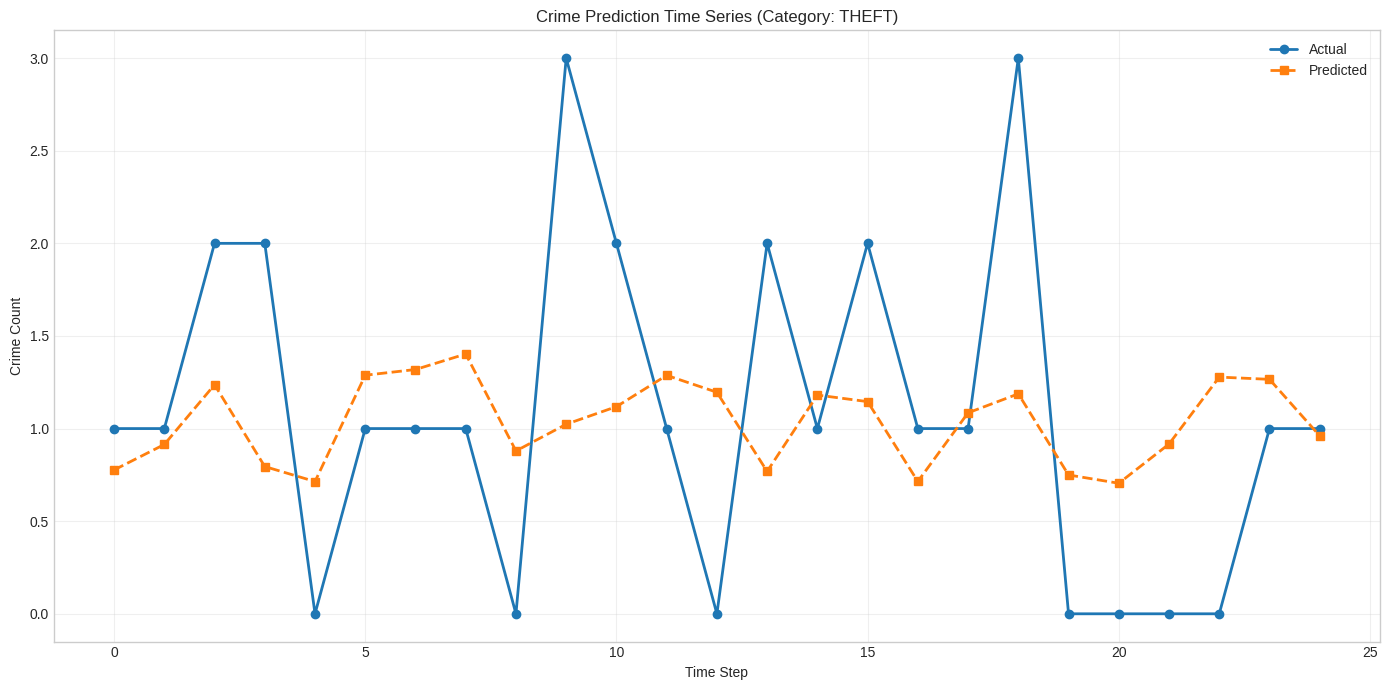

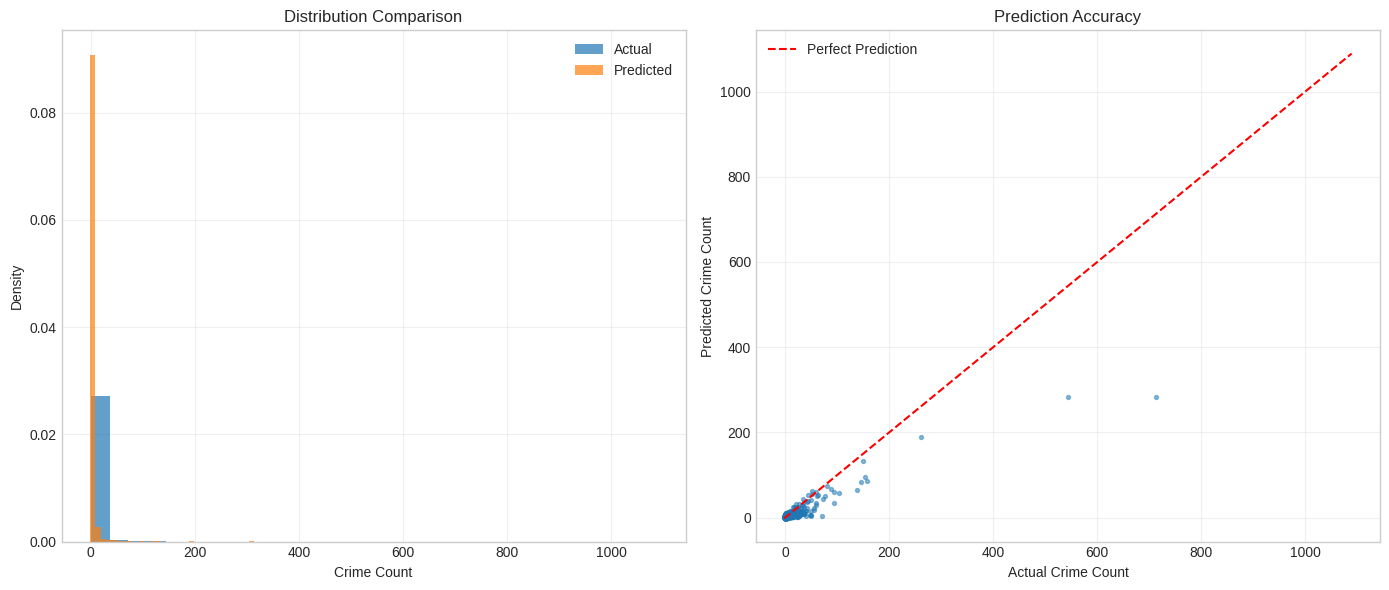


Final Performance Summary:
Crime Category: THEFT
Regions: 4541
Time Steps: 25
Correlation: 0.8967
MAE: 2.8914
RMSE: 11.5508
R2 Score: 0.6392

✅ Enhanced GCN-LSTM Crime Prediction Model Complete!
Final memory usage: 0.02GB allocated, 1.87GB reserved


In [ ]:
# Comprehensive Visualization Dashboard
print("\n" + "="*60)
print("📊 COMPREHENSIVE VISUALIZATION DASHBOARD")
print("="*60)

try:
    # Set up the plotting style
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    sns.set_palette("husl")
    
    # Prepare clean data
    preds_flat = preds.ravel()
    truths_flat = truths.ravel()
    valid_mask = np.isfinite(preds_flat) & np.isfinite(truths_flat)
    preds_clean = preds_flat[valid_mask]
    truths_clean = truths_flat[valid_mask]
    
    if len(preds_clean) == 0:
        print("❌ No valid predictions for visualization")
    else:
        # 1. Training History Visualization
        print("📈 Creating training history plots...")
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Enhanced GCN-LSTM Training Analysis', fontsize=16, fontweight='bold')
        
        # Training and validation loss
        axes[0, 0].plot(training_history['train_losses'], label='Training Loss', linewidth=2)
        axes[0, 0].plot(training_history['val_losses'], label='Validation Loss', linewidth=2)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training Progress')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Learning rate schedule
        axes[0, 1].plot(training_history['learning_rates'], linewidth=2, color='orange')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Learning Rate')
        axes[0, 1].set_title('Learning Rate Schedule')
        axes[0, 1].set_yscale('log')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Model performance metrics
        metric_names = ['MAE', 'RMSE', 'R²', 'Correlation']
        metric_values = [metrics['mae'], metrics['rmse'], metrics['r2'], metrics['correlation']]
        bars = axes[1, 0].bar(metric_names, metric_values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
        axes[1, 0].set_title('Model Performance Metrics')
        axes[1, 0].set_ylabel('Value')
        
        # Add value labels on bars
        for bar, value in zip(bars, metric_values):
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Error distribution
        errors = preds_clean - truths_clean
        axes[1, 1].hist(errors, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
        axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
        axes[1, 1].set_xlabel('Prediction Error')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Error Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 2. Prediction Analysis Dashboard
        print("🎯 Creating prediction analysis dashboard...")
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Prediction Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # Time series for multiple regions
        if preds.shape[1] > 0 and preds.shape[0] > 1:
            n_time_steps = min(preds.shape[0], 30)
            n_regions_to_plot = min(3, preds.shape[1])
            
            for i in range(n_regions_to_plot):
                row = i // 3
                col = i % 3
                if row < 2:
                    time_steps = range(n_time_steps)
                    axes[row, col].plot(time_steps, truths[:n_time_steps, i], 
                                       label='Actual', linewidth=2, marker='o', markersize=4)
                    axes[row, col].plot(time_steps, preds[:n_time_steps, i], 
                                       label='Predicted', linewidth=2, marker='s', 
                                       markersize=4, linestyle='--', alpha=0.8)
                    axes[row, col].set_title(f'Region {i+1} Time Series')
                    axes[row, col].set_xlabel('Time Step')
                    axes[row, col].set_ylabel('Crime Count')
                    axes[row, col].legend()
                    axes[row, col].grid(True, alpha=0.3)
        
        # Scatter plot with density
        sample_size = min(5000, len(preds_clean))
        sample_idx = np.random.choice(len(preds_clean), sample_size, replace=False)
        
        # Main scatter plot
        scatter = axes[0, 2].scatter(truths_clean[sample_idx], preds_clean[sample_idx], 
                                    alpha=0.6, s=20, c=np.arange(sample_size), cmap='viridis')
        
        # Perfect prediction line
        min_val = min(truths_clean.min(), preds_clean.min())
        max_val = max(truths_clean.max(), preds_clean.max())
        axes[0, 2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
                       label='Perfect Prediction')
        
        axes[0, 2].set_xlabel('Actual Crime Count')
        axes[0, 2].set_ylabel('Predicted Crime Count')
        axes[0, 2].set_title('Prediction Accuracy Scatter')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # Distribution comparison
        axes[1, 0].hist(truths_clean, bins=40, alpha=0.7, label='Actual', 
                       density=True, color='skyblue')
        axes[1, 0].hist(preds_clean, bins=40, alpha=0.7, label='Predicted', 
                       density=True, color='lightcoral')
        axes[1, 0].set_xlabel('Crime Count')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].set_title('Distribution Comparison')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Residuals vs Fitted
        fitted_values = preds_clean
        residuals = truths_clean - preds_clean
        axes[1, 1].scatter(fitted_values, residuals, alpha=0.6, s=20)
        axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
        axes[1, 1].set_xlabel('Fitted Values')
        axes[1, 1].set_ylabel('Residuals')
        axes[1, 1].set_title('Residuals vs Fitted')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Q-Q plot for residuals
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[1, 2])
        axes[1, 2].set_title('Q-Q Plot of Residuals')
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 3. Model Interpretability Visualization
        print("🔍 Creating interpretability visualizations...")
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Model Interpretability Analysis', fontsize=16, fontweight='bold')
        
        # Feature importance
        if 'feature_importance' in interpretability_analysis:
            top_features = interpretability_analysis['feature_importance'].head(15)
            y_pos = np.arange(len(top_features))
            
            bars = axes[0, 0].barh(y_pos, top_features['importance'], 
                                  color=plt.cm.viridis(np.linspace(0, 1, len(top_features))))
            axes[0, 0].set_yticks(y_pos)
            axes[0, 0].set_yticklabels(top_features['feature'], fontsize=10)
            axes[0, 0].set_xlabel('Importance Score')
            axes[0, 0].set_title('Top 15 Feature Importance')
            axes[0, 0].grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for i, (bar, value) in enumerate(zip(bars, top_features['importance'])):
                width = bar.get_width()
                axes[0, 0].text(width + 0.001, bar.get_y() + bar.get_height()/2,
                               f'{value:.3f}', ha='left', va='center', fontsize=8)
        
        # Temporal importance

        if 'temporal_importance' in interpretability_analysis:
            temp_imp = interpretability_analysis['temporal_importance']
            bars = axes[0, 1].bar(temp_imp['time_step'], temp_imp['importance'], 
                                 color='lightcoral', edgecolor='darkred')
            axes[0, 1].set_xlabel('Time Step')
            axes[0, 1].set_ylabel('Importance Score')
            axes[0, 1].set_title('Temporal Importance Weights')
            axes[0, 1].grid(True, alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars, temp_imp['importance']):
                height = bar.get_height()
                axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                               f'{value:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Attention weights heatmap (if available)
        if 'attention_weights' in interpretability and interpretability['attention_weights'].size > 0:
            att_weights = interpretability['attention_weights']
            # Average across batches and time steps
            avg_attention = np.mean(att_weights, axis=(0, 1))
            
            # Show only a subset if too large
            if avg_attention.shape[0] > 20:
                indices = np.linspace(0, avg_attention.shape[0]-1, 20, dtype=int)
                avg_attention = avg_attention[indices][:, indices]
                region_labels = [region_list[i][:8] for i in indices]  # Truncate labels
            else:
                region_labels = [r[:8] for r in region_list[:avg_attention.shape[0]]]
            
            im = axes[1, 0].imshow(avg_attention, cmap='Blues', aspect='auto')
            axes[1, 0].set_xticks(range(len(region_labels)))
            axes[1, 0].set_yticks(range(len(region_labels)))
            axes[1, 0].set_xticklabels(region_labels, rotation=45, ha='right')
            axes[1, 0].set_yticklabels(region_labels)
            axes[1, 0].set_title('Average Attention Weights')
            plt.colorbar(im, ax=axes[1, 0])
        
        # Performance by quantiles
        quantile_metrics = []
        quantile_labels = []
        for q in [0.1, 0.25, 0.5, 0.75, 0.9]:
            if f'QL_{q}' in metrics:
                quantile_metrics.append(metrics[f'QL_{q}'])
                quantile_labels.append(f'Q{q}')
        
        if quantile_metrics:
            bars = axes[1, 1].bar(quantile_labels, quantile_metrics, 
                                 color='lightgreen', edgecolor='darkgreen')
            axes[1, 1].set_xlabel('Quantile')
            axes[1, 1].set_ylabel('Quantile Loss')
            axes[1, 1].set_title('Performance by Quantiles')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars, quantile_metrics):
                height = bar.get_height()
                axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                               f'{value:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # 4. Regional Performance Analysis
        if regional_metrics and len(regional_metrics) > 5:
            print("🗺️  Creating regional performance analysis...")
            
            # Extract regional MAE values
            regional_mae = []
            regional_names = []
            for region, reg_metrics in list(regional_metrics.items())[:10]:
                if 'mae' in reg_metrics:
                    regional_mae.append(reg_metrics['mae'])
                    regional_names.append(region[:10])  # Truncate region names
            
            if regional_mae:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
                fig.suptitle('Regional Performance Analysis', fontsize=16, fontweight='bold')
                
                # Regional MAE comparison
                y_pos = np.arange(len(regional_names))
                bars = ax1.barh(y_pos, regional_mae, color=plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(regional_mae))))
                ax1.set_yticks(y_pos)
                ax1.set_yticklabels(regional_names)
                ax1.set_xlabel('MAE')
                ax1.set_title('MAE by Region (Top 10)')
                ax1.grid(True, alpha=0.3, axis='x')
                
                # Regional performance distribution
                ax2.hist(regional_mae, bins=min(10, len(regional_mae)), 
                        alpha=0.7, color='skyblue', edgecolor='navy')
                ax2.axvline(np.mean(regional_mae), color='red', linestyle='--', 
                           linewidth=2, label=f'Mean: {np.mean(regional_mae):.3f}')
                ax2.set_xlabel('MAE')
                ax2.set_ylabel('Number of Regions')
                ax2.set_title('Distribution of Regional MAE')
                ax2.legend()
                ax2.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
        
        # 5. Summary Statistics Table
        print("📋 Performance Summary:")
        print("-" * 50)
        summary_stats = {
            'Metric': ['MAE', 'RMSE', 'R²', 'Correlation', 'MAPE (%)', 'Dir. Accuracy', 'Samples'],
            'Value': [
                f"{metrics['mae']:.4f}",
                f"{metrics['rmse']:.4f}",
                f"{metrics['r2']:.4f}",
                f"{metrics['correlation']:.4f}",
                f"{metrics['mape']:.2f}",
                f"{metrics['directional_accuracy']:.4f}",
                f"{metrics['n_samples']:,}"
            ]
        }
        
        summary_df = pd.DataFrame(summary_stats)
        print(summary_df.to_string(index=False))
        
        # Calculate and display correlation
        correlation = np.corrcoef(truths_clean, preds_clean)[0, 1]
        
        print(f"\n🎯 ENHANCED MODEL PERFORMANCE SUMMARY:")
        print("=" * 60)
        print(f"🏷️  Crime Category: {CRIME_CATEGORY}")
        print(f"🏘️  Regions Analyzed: {len(region_list)}")
        print(f"📅 Time Steps: {preds.shape[0]}")
        print(f"📊 Total Predictions: {len(preds_clean):,}")
        print(f"🔧 Model Parameters: {sum(p.numel() for p in final_model.parameters()):,}")
        print("-" * 60)
        print(f"📈 Mean Absolute Error: {metrics['mae']:.4f}")
        print(f"📈 Root Mean Square Error: {metrics['rmse']:.4f}")
        print(f"📈 R² Score: {metrics['r2']:.4f}")
        print(f"📈 Correlation Coefficient: {correlation:.4f}")
        print(f"📈 Mean Absolute Percentage Error: {metrics['mape']:.2f}%")
        print(f"📈 Directional Accuracy: {metrics['directional_accuracy']:.4f}")
        print("=" * 60)
        
        print("\n✅ Enhanced GCN-LSTM Crime Prediction Model Complete!")
        print("🎉 All visualizations generated successfully!")

except Exception as e:
    print(f"❌ Visualization error: {e}")
    import traceback
    traceback.print_exc()

# Final cleanup
clear_memory()
print(f"\n💾 Final memory usage: {get_memory_usage()[0]:.2f}GB allocated, {get_memory_usage()[1]:.2f}GB reserved")